<a href="https://colab.research.google.com/github/fjadidi2001/fake_news_detection/blob/main/DANES.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load dataset
# Try common encodings
try:
    df = pd.read_csv('facebook-fact-check.csv', encoding='latin1')  # or 'ISO-8859-1'
except UnicodeDecodeError:
    df = pd.read_csv('facebook-fact-check.csv', encoding='windows-1252')
# Convert 'Rating' to binary labels (1 for fake, 0 otherwise)
df['label'] = df['Rating'].apply(lambda x: 1 if x == 'no factual content' else 0)

# Text preprocessing
texts = df['Context Post'].fillna('').astype(str)
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, maxlen=200)

# Social features preprocessing
social_features = df[['share_count', 'reaction_count', 'comment_count']].fillna(0)
scaler = StandardScaler()
social_scaled = scaler.fit_transform(social_features)

# Split data into train and test sets
X_text_train, X_text_test, X_social_train, X_social_test, y_train, y_test = train_test_split(
    padded_sequences, social_scaled, df['label'], test_size=0.2, random_state=42
)

In [3]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Reshape, concatenate

# Text Branch
text_input = Input(shape=(200,))
embedding = Embedding(input_dim=10000, output_dim=128)(text_input)
conv1d_text = Conv1D(filters=64, kernel_size=5, activation='relu')(embedding)
pool_text = MaxPooling1D(pool_size=2)(conv1d_text)
flatten_text = Flatten()(pool_text)

# Social Branch
social_input = Input(shape=(3,))
reshape_social = Reshape((3, 1))(social_input)  # Reshape for Conv1D
conv1d_social = Conv1D(filters=64, kernel_size=2, activation='relu')(reshape_social)
pool_social = MaxPooling1D(pool_size=1)(conv1d_social)
flatten_social = Flatten()(pool_social)

# Concatenate and Classify
concat = concatenate([flatten_text, flatten_social])
dense1 = Dense(64, activation='relu')(concat)
output = Dense(1, activation='sigmoid')(dense1)

model = Model(inputs=[text_input, social_input], outputs=output)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 200)            │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_1             │ (None, 3)              │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, 200, 128)       │      1,280,000 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 3, 1)           │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 196, 64)        │         41,024 │ embedding[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_1 (Conv1D)         │ (None, 2, 64)          │            192 │ reshape[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d             │ (None, 98, 64)         │              0 │ conv1d[0][0]           │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling1d_1           │ (None, 2, 64)          │              0 │ conv1d_1[0][0]         │
│ (MaxPooling1D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 6272)           │              0 │ max_pooling1d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 128)            │              0 │ max_pooling1d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 6400)           │              0 │ flatten[0][0],         │
│                           │                        │                │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense (Dense)             │ (None, 64)             │        409,664 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 1)              │             65 │ dense[0][0]            │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,730,945 (6.60 MB)

 Trainable params: 1,730,945 (6.60 MB)

 Non-trainable params: 0 (0.00 B)

In [4]:
history = model.fit(
    [X_text_train, X_social_train], y_train,
    validation_data=([X_text_test, X_social_test], y_test),
    epochs=10,
    batch_size=32
)

Epoch 1/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.8770 - loss: 0.4188 - val_accuracy: 0.8950 - val_loss: 0.2734
Epoch 2/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.8809 - loss: 0.3124 - val_accuracy: 0.9037 - val_loss: 0.2733
Epoch 3/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.9204 - loss: 0.2153 - val_accuracy: 0.9147 - val_loss: 0.3088
Epoch 4/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8700 - loss: 0.2702 - val_accuracy: 0.9190 - val_loss: 0.2925
Epoch 5/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9362 - loss: 0.1875 - val_accuracy: 0.9125 - val_loss: 0.3531
Epoch 6/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9469 - loss: 0.1607 - val_accuracy: 0.9081 - val_loss: 0.3865
Epoch 7/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9470 - loss: 0.1497 - val_accuracy: 0.9103 - val_loss: 0.3943
Epoch 8/10
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9350 - loss: 0.1728 - val_accuracy: 0.9015 - val_loss

## Text Preprocessing & Word Embeddings

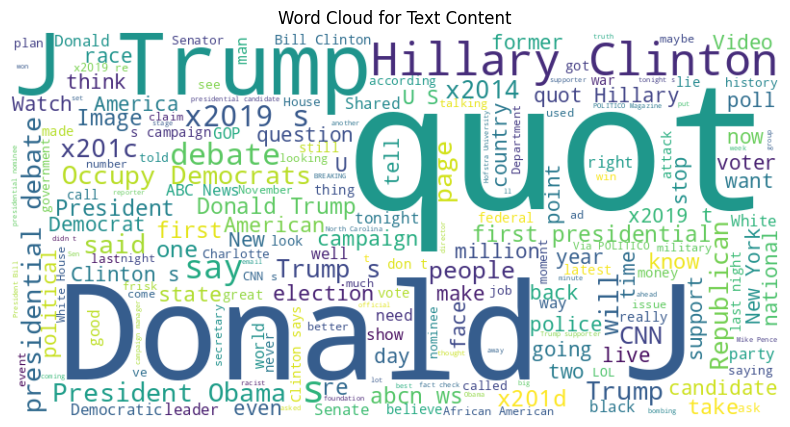

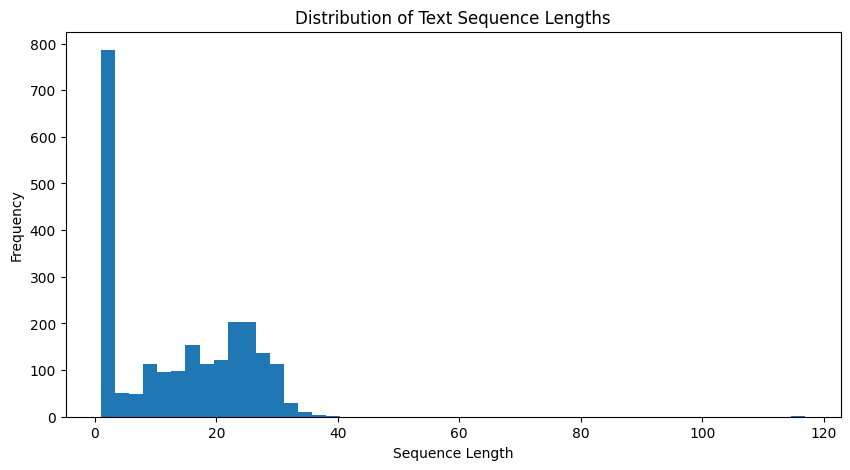

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


# Create binary labels
df['label'] = df['Rating'].apply(lambda x: 1 if x == 'no factual content' else 0)

# Text Preprocessing
texts = df['Context Post'].fillna('').astype(str)

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(texts))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud for Text Content')
plt.show()

# Tokenization and Padding
tokenizer = Tokenizer(num_words=10000)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, maxlen=200)

# Plot sequence length distribution
sequence_lengths = [len(seq) for seq in sequences]
plt.figure(figsize=(10, 5))
plt.hist(sequence_lengths, bins=50)
plt.xlabel('Sequence Length')
plt.ylabel('Frequency')
plt.title('Distribution of Text Sequence Lengths')
plt.show()

## Social Context Embedding

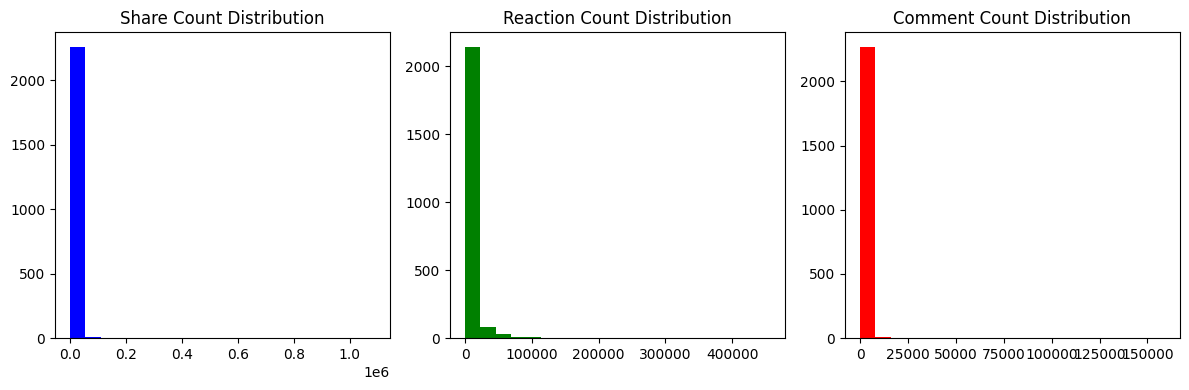

In [6]:
from sklearn.preprocessing import StandardScaler

# Extract social features (assuming these represent aggregated reactions)
social_features = df[['share_count', 'reaction_count', 'comment_count']].fillna(0)

# Scale features
scaler = StandardScaler()
social_scaled = scaler.fit_transform(social_features)

# Visualize social features
plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.hist(social_features['share_count'], bins=20, color='blue')
plt.title('Share Count Distribution')

plt.subplot(1, 3, 2)
plt.hist(social_features['reaction_count'], bins=20, color='green')
plt.title('Reaction Count Distribution')

plt.subplot(1, 3, 3)
plt.hist(social_features['comment_count'], bins=20, color='red')
plt.title('Comment Count Distribution')

plt.tight_layout()
plt.show()